<a name="main"></a>

##  <a href="../index.html#relaciones_interprovinciales_en_espanha" style="color:grey;text-decoration: none"> < Volver al Índice

----------------------------
<div style="text-align:center"><span style="color:green; font-family:Georgia; font-size:3em;">Relaciones Interprovinciales en España</span></div>

--------------------------------------------

<a name="setup"></a> 

<div style="text-align:justify"><span style="color:blue; font-family:Georgia; font-size:2em;">[I] Setup</span></div>

# Descarga de los Ficheros de Nacimientos

Descargamos los ficheros de Nacimientos correspondientes a los años que queremos analizar, en la siguiente dirección del INE:

http://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736177007&menu=resultados&secc=1254736195443&idp=1254735573002

Solamente nos descargamos los ficheros posteriores a 2007, porque los de años anteriores involucran metodologías heterogéneas.

En nuestro directorio de trabajo los almacenamos en la carpeta **/despues_2007**, separando por un lado los ficheros de microdatos propios de cada año, de los metadatos que vienen con cada uno de ellos, y que son iguales para todos. 

Los microdatos van en **/despues_2007/microdatos**, y los metadatos en **/despues_2007/metadatos**

Tenemos además otra carpeta con todos los metadatos que hemos traído de otras fuentes, ubicada en **/despues_2007/metadatos/externos**

# Imports

In [245]:
import pandas
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import math
from collections import Counter

# Metadatos

### INE.Nacimientos

El INE nos proporciona 2 ficheros excel de metadatos para los Nacimientos a partir del 2007:
* *Diseñoanonimizadonacimientos.xls*

* *Valores válidosDiseñoanonimizadonacimientos.xls*

Lo único que ahora nos interesa de ellos son 3 columnas del primero, que nos indican la Longitud fija que ocupan los registros de cada columna de microdatos, sus Nombres, y la Descripción de lo que representan.

In [246]:
metadatos_ine = pandas.read_excel("despues_2007/metadatos/Diseñoanonimizadonacimientos.xls", 0)
metadatos_ine = metadatos[['Longitud','Nombre','Descripción']]

In [247]:
metadatos_ine.head()

,Longitud,Nombre,Descripción
0,2,PROI,PROVINCIA DE INSCRIPCIÓN
1,3,MUNI,MUNICIPIO DE INSCRIPCIÓN
2,2,MESPAR,MES DEL PARTO
3,4,ANOPAR,AÑO DEL PARTO
4,2,PROPAR,PROVINCIA DEL PARTO


### Externos

Los metadatos que nos proporciona el INE en los mismos ficheros de Nacimientos son insuficientes, ya que las provincias están representadas según un código numérico, por lo que necesitamos un mapping que nos dé los nombres reales de las provincias. El mapping lo podemos encontrar aquí:

https://www.ine.es/daco/daco42/codmun/cod_provincia.htm

Además, también nos interesa poder agrupar las provincias por CCAA, y tener accesibles de forma programática sus gentilicios masculino y femeninos

Una vez reunidos todos estos datos, los agrupamos en el archivo  **/despues_2007/metadatos/externos/metadatos_provincias.txt**

In [248]:
metadatos_provincias = pandas.read_csv("despues_2007/metadatos/externos/metadatos_provincias.txt", '\t', encoding = 'iso8859_3')
metadatos_provincias.head()

,Código,Provincia,CCAA,gen_mas,gen_fem
0,2,Albacete,Castilla La Mancha,albaceteño,albaceteña
1,3,Alacant,Valencia,alicantino,alicantina
2,4,Almería,Andalucía,almeriense,almeriense
3,1,Araba,País Vasco,alavés,alavesa
4,33,Asturias,Asturias,asturiano,asturiana


Creamos algunos diccionarios que relacionen las columnas de este DF:

In [249]:
dict_cod_prov  = {provincia[1]: provincia[2] for provincia in metadatos_provincias.itertuples()}
dict_prov_ccaa = {provincia[2]: provincia[3] for provincia in metadatos_provincias.itertuples()}
dict_gen_mas   = {provincia[2]: provincia[4] for provincia in metadatos_provincias.itertuples()}
dict_gen_fem   = {provincia[2]: provincia[5] for provincia in metadatos_provincias.itertuples()}

Además, a partir de las estadísticas económicas del INE, obtenemos el PIB per Cápita de cada provincia y de cada Comunidad Autónoma, que nos servirá para ordenarlas de algún modo significativo en las ilustraciones.

https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736167628&menu=resultados&idp=1254735576581

Los guardamos en los ficheros **/despues_2007/metadatos/externos/pip_pc_provincia.txt** y         **/despues_2007/metadatos/externos/pip_pc_ccaa.txt** 

In [250]:
pip_pc_provincia = pandas.read_csv("despues_2007/metadatos/externos/pip_pc_provincia.txt", '\t', encoding = 'iso8859_3')
pip_pp_ccaa = pandas.read_csv("despues_2007/metadatos/externos/pip_pp_ccaa.txt", '\t', encoding = 'iso8859_3')

pip_pc_provincia.sort_values("pip_pc", ascending = False).head()

,Provincia,pip_pc,pop
46,Araba,36066,323
43,Madrid,32857,6446
48,Gipuzcoa,31486,708
47,Bizkaia,30378,1134
45,Navarra,29859,638


In [251]:
pip_pp_ccaa.sort_values("pip_pc_ccaa", ascending = False).head()

,CCAA,pip_pc_ccaa
12,Madrid,33824
15,País Vasco,32969
14,Navarra,30853
8,Cataluña,30064
1,Aragón,27648


# Provincias Agrupadas y Ordenadas

Con estos datos podemos crear una lista ordenada de Provincias, agrupadas por CCAA, ordenadas las CCAA por PIB per Cápita, y ordenadas también por PIB per Cápita las provincia dentro de su CCAA:

In [252]:
provincias_ccaa = metadatos_provincias[['Provincia','CCAA']]

provincias_ordenadas = pip_pc_provincia.set_index('Provincia').join(provincias_ccaa.set_index('Provincia'), how = 'left')
provincias_ordenadas = provincias_ordenadas.join(pip_pp_ccaa.set_index('CCAA'), on = 'CCAA', how = 'left')
provincias_ordenadas = provincias_ordenadas.sort_values(['pip_pc_ccaa','pip_pc'], ascending = False)
provincias_ordenadas = provincias_ordenadas.reset_index(drop = False)['Provincia']

provincias_ordenadas[0:10]

0       Madrid
1        Araba
2     Gipuzcoa
3      Bizkaia
4      Navarra
5    Tarragona
6    Barcelona
7       Girona
8       Lleida
9       Huesca
Name: Provincia, dtype: object

In [253]:
dict_provincias_ordenadas = {provincia[2]: provincia[1] for provincia in provincias_ordenadas.reset_index().itertuples()}

provincia_Muestra = "Barcelona"
print(provincia_Muestra + ' va de ' + str(provincias_ordenadas_dict[provincia_Muestra]+1) + 'ª')

Barcelona va de 7ª


# Lectura Microdatos

In [254]:
años = [2017]

ruta = "despues_2007/microdatos/"

if not "DFs_" in vars():
    DFs_ = {}
DFs  = {}
for año in años:  
    try:
        DFs[año] = DFs_[año].copy()
    except KeyError:
        DFs_[año] = pandas.read_fwf(ruta + str(año) + ".txt", widths= metadatos_ine['Longitud'])
        DFs[año] = DFs_[año].copy()

In [255]:
for key in list(DFs.keys()):
    # nombramos columnas
    DFs[key].columns = metadatos_ine['Nombre']
    # nos quedamos con las columnas que nos interesan
    DFs[key] =  DFs[key][['PROMA','PROPA','PROI']]  # prov. nacimiento madre, prov. nacimiento padre y prov. nacimiento niñ@
    # eliminamos filas con valores nulos
    DFs[key] =  DFs[key][np.isfinite( DFs[key]['PROI'])]
    DFs[key] =  DFs[key][np.isfinite( DFs[key]['PROMA'])]
    DFs[key] =  DFs[key][np.isfinite( DFs[key]['PROPA'])]
    # eliminamos filas correspondientes a padres y madres nacidos en el extranjero
    DFs[key] =  DFs[key][DFs[key]['PROMA'] != 99]      
    DFs[key] =  DFs[key][DFs[key]['PROPA'] != 99]
    # substituímos los códigos de las provincias por sus nombres 
    DFs[key] = DFs[key].replace({'PROI':dict_cod_prov})
    DFs[key] = DFs[key].replace({'PROMA':dict_cod_prov})
    DFs[key] = DFs[key].replace({'PROPA':dict_cod_prov})

In [256]:
DFs[año].head().reset_index(drop = True)

Nombre,PROMA,PROPA,PROI
0,Madrid,A Coruña,A Coruña
1,Madrid,León,Madrid
2,Madrid,Madrid,Madrid
3,Barcelona,Barcelona,Barcelona
4,Barcelona,Barcelona,Barcelona


In [280]:
print(' Toda la información que contiene nuestro DataSet es tipo: \n')

for row in DFs[año].head().reset_index(drop = True).itertuples():
    print(str(row[0] + 1) + '- una ' + dict_gen_fem[row[1]] + " y un " + dict_gen_mas[row[2]] + " son padres en " + row[3])
print ('...')

 Toda la información que contiene nuestro DataSet es tipo: 

1- una madrileña y un coruñés son padres en A Coruña
2- una madrileña y un leonés son padres en Madrid
3- una madrileña y un madrileño son padres en Madrid
4- una barcelonesa y un barcelonés son padres en Barcelona
5- una barcelonesa y un barcelonés son padres en Barcelona
...


In [281]:
suavizado_logarítmico = True

matrices = {}

for key in list(DFs.keys()):
    
    # crear matriz de ceros
    matrices[key] = []
    for i in range(0,len(provincias_ordenadas)):
        matrices[key].append([])
        for j in range(0,len(provincias_ordenadas)):
            matrices[key][i].append(0)
            
    # rellenar matriz
    for nac in DFs[key].itertuples():
        try:
            matrices[key][provincias_ordenadas_dict[nac[1]]][provincias_ordenadas_dict[nac[2]]] += 1
        except KeyError:
            continue
            
    if suavizado_logarítmico == True:        
    # suavizar matriz
        for i in range(0,len(provincias_ordenadas)):
            for j in range(0,len(provincias_ordenadas)):
                matrices[key][i][j] = math.log(matrices[key][i][j] + 1)
            
    # etiquetar matriz
    matrices[key] = pandas.DataFrame(matrices[key])
    matrices[key].columns= provincias_ordenadas
    matrices[key].index = provincias_ordenadas

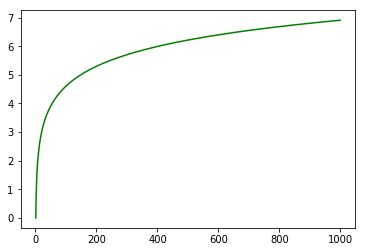

In [282]:
a = np.arange(1,1000,1)
b = [math.log(i) for i in a ]
plt.plot(a, b, color = "g")

In [283]:
minimo_hijos = 0
año_referencia = año

booleanos = list((matrices[año_referencia].sum(1) + matrices[año_referencia].sum(0))/2 > minimo_hijos)
provincias_significativas = pandas.Series(list(provincias_ordenadas_dict.keys())).loc[booleanos]

for key in list(DFs.keys()):
    
    # restringir matriz
    matrices[key] = matrices[key].loc[provincias_significativas,provincias_significativas]

In [285]:
def plot_matriz(matriz, provincias_significativas):
    fig, ax = plt.subplots(1, figsize=(13, 13))
    plt.imshow(matriz, cmap = "Reds", aspect='auto')
    ax.set_yticks(np.arange(len(provincias_significativas)))
    ax.set_yticklabels(list(provincias_significativas))
    ax.set_xticks(np.arange(len(provincias_significativas)))
    ax.set_xticklabels(list(provincias_significativas), rotation=70)
    ax.set_title("Densidad Nacimientos", fontdict = {'fontsize': 30,'fontweight':500}, pad =30)
    ax.set_xlabel('padre',fontweight='bold',fontsize=20, labelpad = 10)
    ax.set_ylabel('madre',fontweight='bold',fontsize=20, labelpad = 10)

    ps = provincias_significativas.reset_index()
    ps.columns = ['i', 'Provincia']
    ccaa_n = ps.join(provincias_ccaa.set_index('Provincia'), how = 'left', on = 'Provincia')['CCAA']
    ccaa_n = list(pandas.DataFrame.from_dict(Counter(ccaa_n), orient='index').iloc[:,0].cumsum().apply(lambda i: i-0.5))

    ax.set_yticks(ccaa_n, minor = True)
    ax.set_xticks(ccaa_n, minor = True)
    ax.grid(which='minor', alpha=1, linewidth = 1.2, linestyle=':', color = 'black')

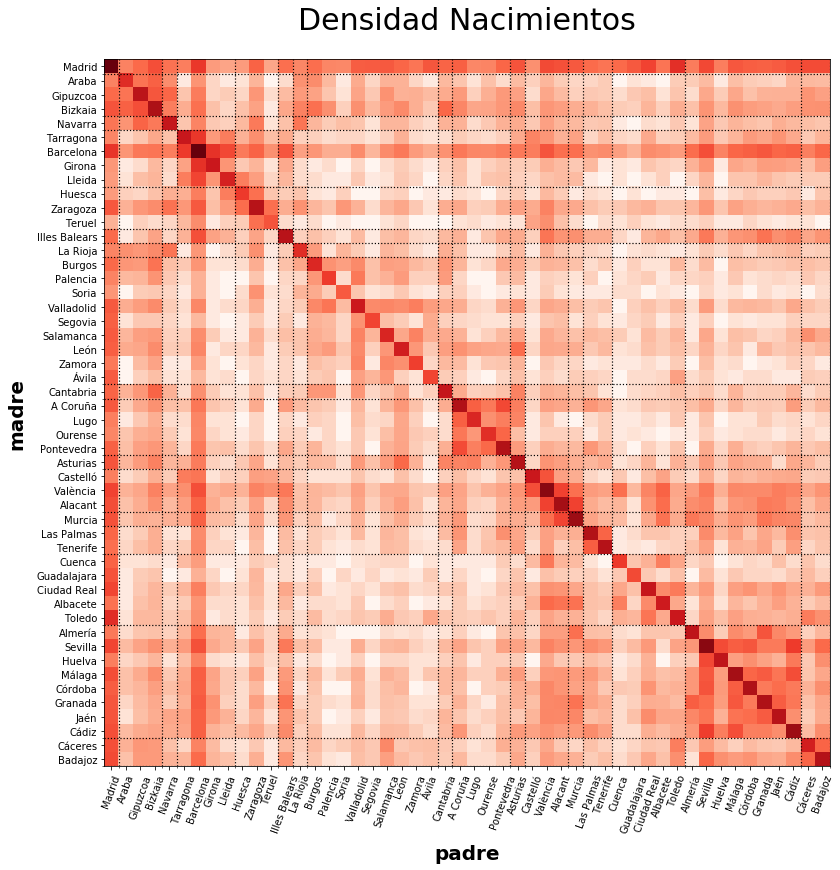

In [286]:
plot_matriz(matrices[año], provincias_significativas)